# Notebook Objectives
The aim of this notebook is to evaluate the model performance in terms of over/under fitting by plotting a learning curve of train/test losses. We also plot the model accuracy when trained using different portions of the data to see if the model would have benifited from a larger size dataset.

In [ ]:
#pip install "dask[complete]"

In [ ]:
#pip install dask-ml

In [ ]:
# Import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# To work with numpy arrays
import numpy as np
# ML model building, training and testing
import sklearn
# Kfold split
from sklearn.model_selection import KFold
# Build ML pipeline
from sklearn.pipeline import Pipeline
# Liner regression model building
from sklearn.linear_model import LinearRegression
# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures
# sklearn included transformer
from sklearn.preprocessing import QuantileTransformer
# to split data into test and train
from sklearn.model_selection import train_test_split
# Scaling transform for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# To run PCA feature reduction
from sklearn.decomposition import PCA
# XGBoost model
from xgboost import XGBRegressor,XGBClassifier
import xgboost as xgb
# Random forest regressor
from sklearn.ensemble import RandomForestRegressor
# for regression error calculation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
# for regression r2 score calculation
from sklearn.metrics import r2_score
# for regression mse score calculation
from sklearn.metrics import mean_squared_error
# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# To transform the target variable into a normal distribution
from sklearn.compose import TransformedTargetRegressor
# visualisation
from matplotlib import pyplot

## Importing the data

In [ ]:
#import csv file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
threerivers_22 = pd.read_csv('/content/drive/threerivers_2022.csv')

In [ ]:
X = threerivers_22.drop('smi',1)
y = threerivers_22['smi']

<ipython-input-4-e7511d9e06fd>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = threerivers_22.drop('smi',1)


In [ ]:
# Dropping some features X, Y, SRB2, SRB3, SRB4 (similar to the paper)
X = X[['aspect','slope','NDMI','MSI','SR_B5','SAVI','EVI','NDVI','ST_B10'
                                ,'MNDWI','SR_B7','SR_B6','MSAVI']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Defining a function to train and test models
def train_test_eval_model(df, reg, features, scale = False, test_size= 0.25, n_pca = None
                     #, early_stop = False
                     ):
  # takes as an input df: dataframe with all independent variables and the output variable. Output variable must be the last column.
  #                   reg: model constructor, example: reg = LinearRegression()
  #                   features: series of features from the dataset to be used for train/test, compute this using X.columns
  #                   scale = Option to scale features prior to training, default = False
  #                   test_size = float, percentage of data to be used for testing. Default = 0.2 (20%)
  #                   n_pca = int, number of principal components to reduce the independent varibles to. Default = None (no pca is done). Recommended to use scale = True if using pca.
  print(type(reg).__name__)

  X = df.iloc[:,:-1] # Select all independent variables as X
  y = df.iloc[:,-1]  # Select the last variable in the dataframe as the target variable y

  # Splitting the data into test (25%) and train (75%)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)

  # Normalize independent variables (both train and test) if required
  if scale == True:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

  # Run PCA if required. Recommended to normalize if PCA will be used
  if n_pca is not None:
    pca = PCA(n_components= n_pca)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

  # Features into a dataframe
  X_train_df= pd.DataFrame(X_train)
  X_test_df= pd.DataFrame(X_test)

  #if early_stop is not False:
  #    reg.fit(X_train_df,y_train, eval_set = [(X_train, y_train), (X_test, y_test)])
  #else:
  #  reg.fit(X_train_df,y_train)

  eval_set = [(X_train, y_train), (X_test, y_test)]
  estimator = reg.fit(X_train_df,y_train, eval_metric=[
      #"error", # use for classification
      #'log_loss' # use for classification
      "rmse",
      'mae'
      ], eval_set = eval_set)

  y_pred_reg = reg.predict(X_test_df)

  results = {}
  r2 = r2_score(y_test, y_pred_reg)
  n = len(y_test)
  k = len(features)
  adj_r2_score = 1-(((1-r2)*(n-1))/(n-k-1))
  mae = mean_absolute_error(y_test,y_pred_reg)
  mse = mean_squared_error(y_test,y_pred_reg)

  print("Features used for model training = ", features)
  print("Number of principal components used for model training = ", n_pca)
  print("MAE = ", mae)
  print("MSE = ", mse)
  print("R2 Score = ", r2 )
  print("Adjusted R2 Score = ", adj_r2_score)

  results['estimator'] = estimator
  results['X_train'] = X_train
  results['y_train'] = y_train
  results['X_test'] = X_test
  results['y_test'] = y_test
  results['y_pred_reg'] = y_pred_reg
  results['MAE'] = mae
  results['MSE'] = mse
  results['R2 Score'] = r2
  results['Adjusted R2 Score'] = adj_r2_score
  results['name'] = type(reg).__name__

  return results

In [ ]:
# XGBoost Regression
xgb_reg = XGBRegressor(
      max_depth= 10
    , learning_rate= 0.05 # learning speed
    , n_estimators = 100 # the number of runs XGBoost will try to learn
    , colsample_bylevel = 0.8 # sample of columns to be used to avoid overfitting
    , objective = 'reg:squarederror' #Objective function for regression
    #, gamma=0.1
    #, early_stopping_rounds = 10
    )
features = ['aspect','slope','NDMI','MSI','SR_B5','SAVI','EVI','NDVI','ST_B10'
                                 ,'MNDWI','SR_B7','SR_B6','MSAVI']
xgb_reg_results = train_test_eval_model(threerivers_22, xgb_reg, features = features, scale = False, test_size= 0.25, n_pca = None
                                   #, early_stop = True
                                   )

XGBRegressor


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.17976	validation_0-mae:0.14742	validation_1-rmse:0.17820	validation_1-mae:0.14559
[1]	validation_0-rmse:0.17102	validation_0-mae:0.14024	validation_1-rmse:0.16957	validation_1-mae:0.13854
[2]	validation_0-rmse:0.16274	validation_0-mae:0.13343	validation_1-rmse:0.16138	validation_1-mae:0.13185
[3]	validation_0-rmse:0.15483	validation_0-mae:0.12693	validation_1-rmse:0.15358	validation_1-mae:0.12547
[4]	validation_0-rmse:0.14733	validation_0-mae:0.12077	validation_1-rmse:0.14618	validation_1-mae:0.11943
[5]	validation_0-rmse:0.14021	validation_0-mae:0.11492	validation_1-rmse:0.13915	validation_1-mae:0.11371
[6]	validation_0-rmse:0.13344	validation_0-mae:0.10937	validation_1-rmse:0.13248	validation_1-mae:0.10827
[7]	validation_0-rmse:0.12700	validation_0-mae:0.10408	validation_1-rmse:0.12612	validation_1-mae:0.10307
[8]	validation_0-rmse:0.12091	validation_0-mae:0.09908	validation_1-rmse:0.12013	validation_1-mae:0.09818
[9]	validation_0-rmse:0.11511	validation_0-mae

In [ ]:
xgb_reg_results['estimator']

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Visualizing the prediction error for training and testing
This plots the prediction error for train and test sets per each epoch (n_estimators variable in XGBoost) to see if the model is under/over fitting

In [ ]:
# Insert the model parameters
param = {'max_depth':10, 'learning_rate':0.1, 'colsample_bylevel':0.8, 'eval_metric':['mae','rmse']}

In [ ]:
def plot_losses(df, test_size = 0.25, param ={} , num_round = 100):
  # Function to plot training and test losses for regression function
  # Takes as input:
  # df : pandas dataframe of features and target variable. target variable must be in the last (right most) column
  # test_size: float, default = 0.25, fraction of test to train
  # param: dictionary, xgboost regression parameters
  # num_round = int, default = 100, number of rounds to run the model (set as the same as n_estimators in model constructor)
  X = df.iloc[:,:-1] # Select all independent variables as X
  y = df.iloc[:,-1]  # Select the last variable in the dataframe as the target variable y
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state=42)
  dtrain = xgb.DMatrix(X_train, label=y_train, nthread=-1)
  dtest = xgb.DMatrix(X_test, label=y_test, nthread=-1)
  param = param
  losses = {}  # Store accuracy result
  num_round = num_round
  watchlist  = [(dtrain,'train'), (dtest, 'eval')]
  bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=losses)
  # Plotting
  fig, ax = pyplot.subplots()
  x_axis = range(0, num_round)
  ax.plot(x_axis, losses['train']['rmse'], label='Train')
  ax.plot(x_axis, losses['eval']['rmse'], label='Test')
  ax.legend()
  pyplot.ylabel('RMSE', fontsize = 14)
  plt.xlabel('Epochs', fontsize = 14)
  pyplot.title('XGBoost Train - Test RMSE')
  pyplot.show()

[0]	train-mae:0.13985	train-rmse:0.17054	eval-mae:0.13813	eval-rmse:0.16908


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-mae:0.12625	train-rmse:0.15400	eval-mae:0.12478	eval-rmse:0.15276
[2]	train-mae:0.11403	train-rmse:0.13915	eval-mae:0.11279	eval-rmse:0.13809
[3]	train-mae:0.10300	train-rmse:0.12572	eval-mae:0.10194	eval-rmse:0.12484
[4]	train-mae:0.09309	train-rmse:0.11366	eval-mae:0.09229	eval-rmse:0.11299
[5]	train-mae:0.08418	train-rmse:0.10280	eval-mae:0.08359	eval-rmse:0.10232
[6]	train-mae:0.07618	train-rmse:0.09304	eval-mae:0.07581	eval-rmse:0.09276
[7]	train-mae:0.06896	train-rmse:0.08425	eval-mae:0.06877	eval-rmse:0.08413
[8]	train-mae:0.06248	train-rmse:0.07637	eval-mae:0.06248	eval-rmse:0.07645
[9]	train-mae:0.05665	train-rmse:0.06929	eval-mae:0.05684	eval-rmse:0.06956
[10]	train-mae:0.05141	train-rmse:0.06290	eval-mae:0.05178	eval-rmse:0.06337
[11]	train-mae:0.04673	train-rmse:0.05719	eval-mae:0.04726	eval-rmse:0.05784
[12]	train-mae:0.04250	train-rmse:0.05203	eval-mae:0.04319	eval-rmse:0.05287
[13]	train-mae:0.03871	train-rmse:0.04743	eval-mae:0.03958	eval-rmse:0.04847
[14]	tra

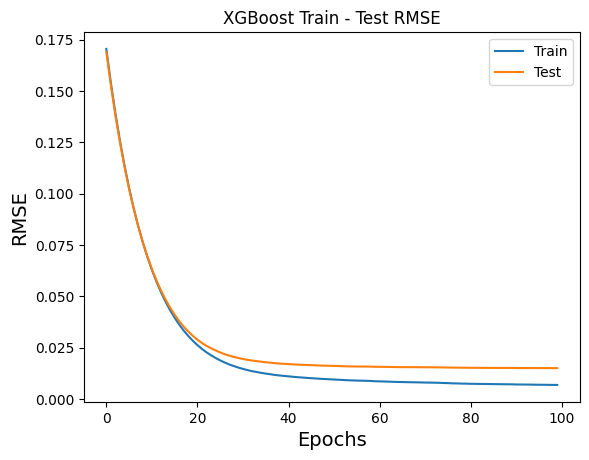

In [ ]:
plot_losses(threerivers_22, param = param)

The general shape of the test and train log loss curves indicates that the error is reduced with training.
The gap between the train and test curve indicates the amount of overfitting in the model (the larger the gap the higher the overfitting - high bias)
https://www.dataquest.io/blog/learning-curves-machine-learning/#:~:text=The%20learning_curve()%20function%20from,will%20take%20care%20of%20that.

As a sense check, train/test losses shown by model training function *'train_test_eval_model()'* are the same as those shown by plotting function *'plot_losses'* when the same parameters are used

## Visualizing training and testing error as a function of the amount of data used to train the model

In [ ]:
from sklearn.model_selection import learning_curve
features = ['aspect','slope','NDMI','MSI','SR_B5','SAVI','EVI','NDVI','ST_B10'
                                 ,'MNDWI','SR_B7','SR_B6','MSAVI']
target = 'smi'
train_sizes = [0.3, 0.5, 0.7, 0.9]
train_sizes, train_scores, validation_scores = learning_curve(estimator = xgb_reg
                                                              ,X = threerivers_22[features].values
                                                              ,y = threerivers_22[target].values
                                                              ,train_sizes = train_sizes
                                                              ,cv = 5
                                                              ,scoring = 'neg_root_mean_squared_error')

In [ ]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[-0.00844706 -0.00975091 -0.00992003 -0.00992003 -0.00992003]
 [-0.0110628  -0.01243208 -0.01221613 -0.01221613 -0.01221613]
 [-0.01278316 -0.01421016 -0.01405554 -0.01396616 -0.01396616]
 [-0.01414579 -0.01548768 -0.01544505 -0.01542207 -0.01516207]]

 ----------------------------------------------------------------------

Validation scores:

 [[-0.0677207  -0.02683255 -0.05012904 -0.06140719 -0.03776909]
 [-0.07372514 -0.02609348 -0.04040593 -0.05745951 -0.03612976]
 [-0.0467585  -0.02581907 -0.03177927 -0.04600298 -0.03471515]
 [-0.04012759 -0.02605327 -0.03144486 -0.03710826 -0.03033328]]


In [ ]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 10032    0.009592
16720    0.012029
23408    0.013796
30096    0.015133
dtype: float64

 --------------------

Mean validation scores

 10032    0.048772
16720    0.046763
23408    0.037015
30096    0.033013
dtype: float64


<ipython-input-16-d52e0ed0b907>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


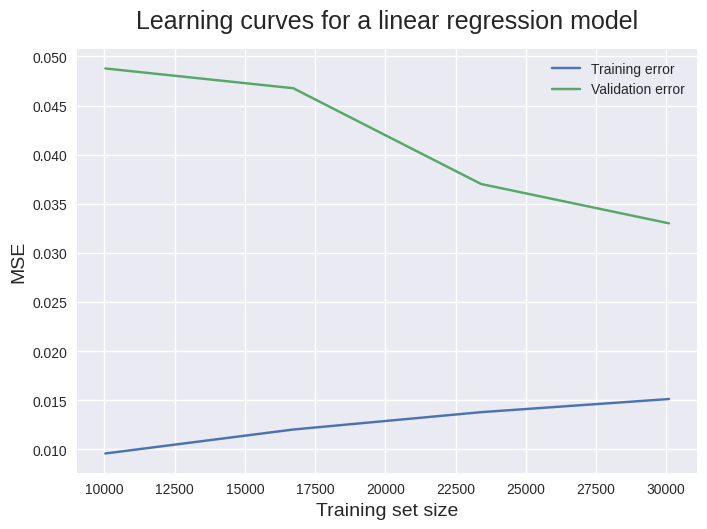

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
#plt.ylim(0,40)

The expectation is that the more training data is added, the higher the training error becomes as it becomes more difficult for the model to fit all the training data, while the validation (test) error decreases with added data as the model becomes better at generalizing for more data points. The closer the two curves the better the model. Two far curves indicates more data could improve the model to converge

In [ ]:
train_size_abs, train_scores, test_scores = learning_curve(
     xgb_reg, X = threerivers_22[features], y = threerivers_22[target], train_sizes=[0.3, 0.5, 0.7, 0.9])
for train_size, cv_train_scores, cv_test_scores in zip(train_size_abs, train_scores, test_scores):
     print(f"{train_size} samples were used to train the model")
     print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
     print(f"The average test accuracy is {cv_test_scores.mean():.2f}")

10032 samples were used to train the model
The average train accuracy is 1.00
The average test accuracy is 0.91
16720 samples were used to train the model
The average train accuracy is 0.99
The average test accuracy is 0.92
23408 samples were used to train the model
The average train accuracy is 0.99
The average test accuracy is 0.95
30096 samples were used to train the model
The average train accuracy is 0.99
The average test accuracy is 0.96
